In [ ]:
#NOTE: This file contains the entire model + training + evaluation + dedubgging cells

In [1]:
import os                       # for working with files
import numpy as np              # for numerical computationss
import pandas as pd             # for working with dataframes
import torch                    # Pytorch module
import matplotlib.pyplot as plt # for plotting informations on graph and images using tensors
import torch.nn as nn           # for creating  neural networks
from torch.utils.data import DataLoader # for dataloaders
from PIL import Image           # for checking images
import torch.nn.functional as F # for functions for calculating loss
import torchvision.transforms as transforms   # for transforming images into tensors
from torchvision.utils import make_grid       # for data checking
from torchvision.datasets import ImageFolder  # for working with classes and images
from torchsummary import summary              # for getting the summary of our model

from torchvision import datasets, transforms, models

%matplotlib inline

In [2]:
# Check if CUDA (GPU) is available
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("GPU is available. Using GPU.")
else:
    device = torch.device('cpu')
    print("GPU not available. Using CPU instead.")

GPU is available. Using GPU.


In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
#train_dir = '/content/drive/My Drive/1. UofT/1. Second Year/APS360/APS360 Project/Corn_Dataset/Corn_Training'
#val_dir = '/content/drive/My Drive/1. UofT/1. Second Year/APS360/APS360 Project/Corn_Dataset/Corn_Validation'

train_dir = '/content/drive/My Drive/Corn_Dataset/Corn_Training'
val_dir = '/content/drive/My Drive/Corn_Dataset/Corn_Validation'

In [ ]:
# List files in one of the class subdirectories: Check to make sure file organization is correct
class_dir = os.path.join(train_dir, 'Corn_train_common_rust_resized')
all_files = os.listdir(class_dir)
print(all_files)
print(os.listdir(class_dir))

[]
[]


In [5]:
# datasets for validation and training and testing
train = ImageFolder(train_dir, transform=transforms.ToTensor())
valid = ImageFolder(val_dir, transform=transforms.ToTensor())

In [6]:
# Setting the seed value
random_seed = 7
torch.manual_seed(random_seed)

In [18]:
# setting the batch size
batch_size = 128

In [19]:
# DataLoaders for training and validation
train_dl = DataLoader(train, batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_dl = DataLoader(valid, batch_size, num_workers=2, pin_memory=True)

In [41]:
# for moving data into GPU (if available)
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available:
        return torch.device("cuda")
    else:
        return torch.device("cpu")

# for moving data to device (CPU or GPU)
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

# for loading in the device (GPU if available else CPU)
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [42]:
device = get_default_device()
print(device)

cuda


In [43]:
# Moving data into GPU
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

In [11]:
class SimpleResidualBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()

    def forward(self, x):
        out = self.conv1(x)
        out = self.relu1(out)
        out = self.conv2(out)
        return self.relu2(out) + x # ReLU can be applied before or after adding the input

In [46]:
# for calculating the accuracy
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

#functions below are the ones used in lab2/lab3 of APS360
def evaluateAlt(net, loader, criterion):
    net.eval()
    total_loss = 0.0
    total_err = 0.0
    total_correct = 0
    total_samples = 0
    with torch.no_grad():
        for i, data in enumerate(loader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs, 1)
            total_correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)
            total_loss += loss.item()
            total_err += (predicted != labels).sum().item()
    accuracy = total_correct / total_samples
    err = float(total_err) / total_samples
    loss = float(total_loss) / (i + 1)
    return accuracy, err, loss



# base class for the model
class ImageClassificationBase(nn.Module):

    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        images = images.to(device)  # Ensure images are on the correct device
        labels = labels.to(device)  # Ensure labels are on the correct device
        out = self(images)                   # Generate prediction
        loss = F.cross_entropy(out, labels)  # Calculate loss
        acc = accuracy(out, labels)          # Calculate accuracy
        return {"val_loss": loss.detach(), "val_accuracy": acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x["val_loss"] for x in outputs]
        batch_accuracy = [x["val_accuracy"] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()       # Combine loss
        epoch_accuracy = torch.stack(batch_accuracy).mean()
        return {"val_loss": epoch_loss, "val_accuracy": epoch_accuracy} # Combine accuracies

    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_accuracy']))

In [13]:
#Architecture for training

# convolution block with BatchNormalization
def ConvBlock(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
             nn.BatchNorm2d(out_channels),
             nn.ReLU(inplace=True)]
    if pool:
        layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)


# resnet architecture
class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_diseases):
        super().__init__()

        self.conv1 = ConvBlock(in_channels, 64)
        self.conv2 = ConvBlock(64, 128, pool=True) # out_dim : 128 x 64 x 64
        self.res1 = nn.Sequential(ConvBlock(128, 128), ConvBlock(128, 128))

        self.conv3 = ConvBlock(128, 256, pool=True) # out_dim : 256 x 16 x 16
        self.conv4 = ConvBlock(256, 512, pool=True) # out_dim : 512 x 4 x 44
        self.res2 = nn.Sequential(ConvBlock(512, 512), ConvBlock(512, 512))

        self.classifier = nn.Sequential(nn.MaxPool2d(16),
                                       nn.Flatten(),
                                       nn.Linear(512, num_diseases))

    def forward(self, xb): # xb is the loaded batch
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [14]:
# defining the model and moving it to the GPU
model = to_device(ResNet9(3, len(train.classes)), device)
print(model)

#model = ResNet9(3, len(train.classes))

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [44]:
for images, labels in train_dl:
    # Check if data is on the same device
    print(images.device, labels.device)
    print(next(model.parameters()).device)
    break  # to avoid printing too much


cuda:0 cuda:0
cuda:0


In [ ]:
# getting summary of the model
INPUT_SHAPE = (3, 128, 128)
print(summary(model.cuda(), (INPUT_SHAPE)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           1,792
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
            Conv2d-4        [-1, 128, 128, 128]          73,856
       BatchNorm2d-5        [-1, 128, 128, 128]             256
              ReLU-6        [-1, 128, 128, 128]               0
         MaxPool2d-7          [-1, 128, 64, 64]               0
            Conv2d-8          [-1, 128, 64, 64]         147,584
       BatchNorm2d-9          [-1, 128, 64, 64]             256
             ReLU-10          [-1, 128, 64, 64]               0
           Conv2d-11          [-1, 128, 64, 64]         147,584
      BatchNorm2d-12          [-1, 128, 64, 64]             256
             ReLU-13          [-1, 128, 64, 64]               0
           Conv2d-14          [-1, 256,

In [33]:
# for training
@torch.no_grad()
def evaluate(model, val_loader):
    device = next(model.parameters()).device
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']


def fit_OneCycle(epochs, max_lr, model, train_loader, val_loader, weight_decay=0,
                grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    #Ensure model is on the GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)  # Move model to GPU

    criterion = nn.CrossEntropyLoss()
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # scheduler for one cycle learniing rate
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, steps_per_epoch=len(train_loader))

    #Alternative
    train_err = np.zeros(epochs)
    train_loss = np.zeros(epochs)
    train_acc = np.zeros(epochs)
    val_err = np.zeros(epochs)
    val_loss = np.zeros(epochs)
    val_acc = np.zeros(epochs)
    i = 0;

    for epoch in range(epochs):
        # Training
        model.train()
        total_train_loss = 0.0
        total_train_err = 0.0
        total_train_correct = 0
        total_train_samples = 0
        train_losses = []
        lrs = []
        i = i + 1

        for batch in train_loader:
            # Move input data to the GPU
            images, labels = batch
            images = images.to(device)  # Move images to GPU
            labels = labels.to(device)  # Move labels to GPU

            loss = model.training_step((images, labels)) #batch
            train_losses.append(loss)
            loss.backward()

             # gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # recording and updating learning rates
            lrs.append(get_lr(optimizer))
            sched.step()

            #Alternative
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)
            labels = labels.long()
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs, 1)
            total_train_correct += (predicted == labels).sum().item()
            total_train_samples += labels.size(0)
            total_train_loss += loss.item()
            total_train_err += (predicted != labels).sum().item()

        # validation
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)

        #Other result
        train_acc[epoch] = total_train_correct / total_train_samples
        train_err[epoch] = float(total_train_err) / total_train_samples
        train_loss[epoch] = float(total_train_loss) / (i + 1)
        val_acc[epoch], val_err[epoch], val_loss[epoch] = evaluateAlt(model, val_loader, criterion)
        print(f"Epoch {epoch + 1}: Train Acc: {train_acc[epoch]:.4f}, Train err: {train_err[epoch]:.4f}, Train loss: {train_loss[epoch]:.4f} | Validation Acc: {val_acc[epoch]:.4f}, Validation err: {val_err[epoch]:.4f}, Validation loss: {val_loss[epoch]:.4f}")

        # Save the model
        model_path = f"model_{model.__class__.__name__}_bs{batch_size}_lr{max_lr}_epoch{epoch + 1}.pth"
        torch.save(model.state_dict(), model_path)

    print('Finished Training')

    epochs = np.arange(1, epochs + 1)
    np.savetxt(f"{model.__class__.__name__}_train_acc.csv", train_acc)
    np.savetxt(f"{model.__class__.__name__}_train_err.csv", train_err)
    np.savetxt(f"{model.__class__.__name__}_train_loss.csv", train_loss)
    np.savetxt(f"{model.__class__.__name__}_val_acc.csv", val_acc)
    np.savetxt(f"{model.__class__.__name__}_val_err.csv", val_err)
    np.savetxt(f"{model.__class__.__name__}_val_loss.csv", val_loss)

    return history

In [ ]:
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            nn.init.xavier_uniform_(m.weight)  # Xavier initialization for Conv2d layers
            if m.bias is not None:
                nn.init.zeros_(m.bias)
        elif isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)  # Xavier initialization for Linear layers
            if m.bias is not None:
                nn.init.zeros_(m.bias)

# Example usage
initialize_weights(model)


In [16]:
%%time
history = [evaluate(model, valid_dl)]
history

CPU times: user 1.51 s, sys: 243 ms, total: 1.76 s
Wall time: 1min 27s


[{'val_loss': tensor(1.7925, device='cuda:0'), 'val_accuracy': tensor(0.1562)}]

In [17]:
epochs = 100
max_lr = 0.01 #default: 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [47]:
%%time
history += fit_OneCycle(epochs, max_lr, model, train_dl, valid_dl,
                             grad_clip=grad_clip,
                             weight_decay=1e-4,
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00042, train_loss: 0.2244, val_loss: 0.5758, val_acc: 0.7780
Epoch 1: Train Acc: 0.9358, Train err: 0.0642, Train loss: 1.1321 | Validation Acc: 0.8024, Validation err: 0.1976, Validation loss: 0.5758
Epoch [1], last_lr: 0.00050, train_loss: 0.1791, val_loss: 0.2736, val_acc: 0.9345
Epoch 2: Train Acc: 0.9352, Train err: 0.0648, Train loss: 0.6772 | Validation Acc: 0.9262, Validation err: 0.0738, Validation loss: 0.2736
Epoch [2], last_lr: 0.00062, train_loss: 0.1643, val_loss: 2.0275, val_acc: 0.5206
Epoch 3: Train Acc: 0.9502, Train err: 0.0498, Train loss: 0.4714 | Validation Acc: 0.6286, Validation err: 0.3714, Validation loss: 2.0275
Epoch [3], last_lr: 0.00080, train_loss: 0.1879, val_loss: 0.3824, val_acc: 0.8691
Epoch 4: Train Acc: 0.9372, Train err: 0.0628, Train loss: 0.4033 | Validation Acc: 0.8405, Validation err: 0.1595, Validation loss: 0.3824
Epoch [4], last_lr: 0.00103, train_loss: 0.2191, val_loss: 0.4812, val_acc: 0.8598
Epoch 5: Train Acc: 0.919

In [ ]:
#Plotting

def plot_accuracies(history):
    accuracies = [x['val_accuracy'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

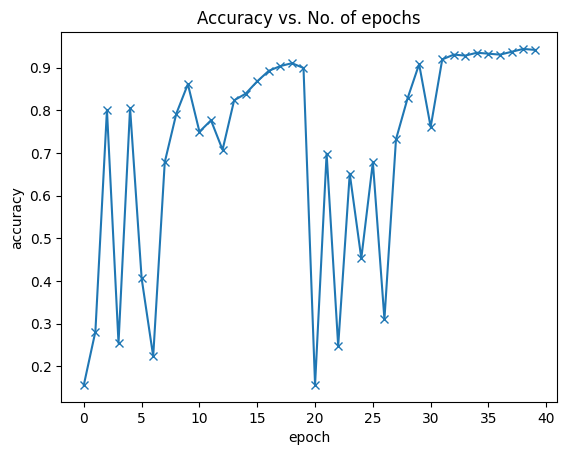

In [ ]:
#Validation Accuracy
plot_accuracies(history)

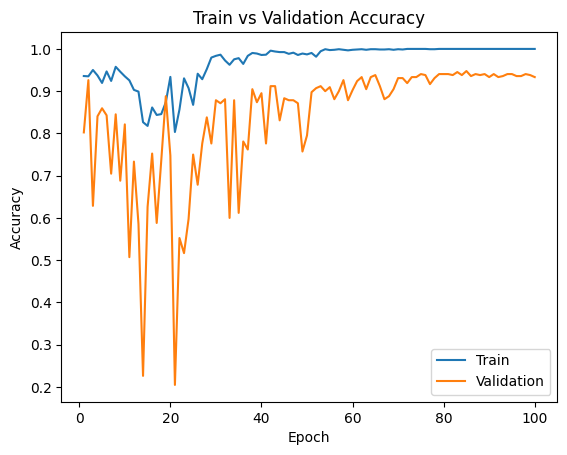

In [49]:
#Alternative Plotting

def plot_acc():
    import matplotlib.pyplot as plt
    train_acc = np.loadtxt("/content/ResNet9_train_acc.csv") #Change this as needed
    val_acc = np.loadtxt("/content/ResNet9_val_acc.csv")
    plt.title("Train vs Validation Accuracy")
    n = len(train_acc) # number of epochs
    plt.plot(range(1,n+1), train_acc, label="Train")
    plt.plot(range(1,n+1), val_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()
plot_acc()

In [ ]:
# Save the model checkpoint
def save_checkpoint(model, epoch, filepath):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
    }, filepath)

# Example usage
save_checkpoint(model, epoch=18, filepath='model_epoch_18_val_acc_89.pth')

#Default parameters for 9 epochs, then lr = 0.05 for the last 10

In [ ]:
# Save the model checkpoint
def save_checkpoint(model, epoch, filepath):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
    }, filepath)

# Example usage
save_checkpoint(model, epoch=40, filepath='model_epoch_40_round_2')

#Default parameters for 20 epochs except lr = 0.005
#Accuracy about 93.81%

In [ ]:
# Save the model checkpoint
def save_checkpoint(model, epoch, filepath):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
    }, filepath)

# Example usage
modelOld = ResNet9(3, len(train.classes))
save_checkpoint(model, epoch=0, filepath='/content/model_epoch_20_val_acc_91')

#Default parameters for 9 epochs, then lr = 0.05 for the last 10

In [54]:
# Load the model checkpoint
def load_checkpoint(filepath, model):
    checkpoint = torch.load(filepath)
    model.load_state_dict(checkpoint['model_state_dict'])
    return checkpoint['epoch']

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

start_epoch = load_checkpoint('/content/model_ResNet9_bs128_lr0.01_epoch85.pth', model)



KeyError: 'model_state_dict'

In [62]:
def load_checkpoint(filepath, model):
    checkpoint = torch.load(filepath)
    model.load_state_dict(checkpoint)  # Load the entire checkpoint as state_dict
    return 0  # Return 0 as the start epoch since it wasn't saved

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

start_epoch = load_checkpoint('/content/model_ResNet9_bs128_lr0.01_epoch75.pth', model)

In [55]:
checkpoint = torch.load('/content/model_ResNet9_bs128_lr0.01_epoch85.pth')
print(checkpoint.keys())

odict_keys(['conv1.0.weight', 'conv1.0.bias', 'conv1.1.weight', 'conv1.1.bias', 'conv1.1.running_mean', 'conv1.1.running_var', 'conv1.1.num_batches_tracked', 'conv2.0.weight', 'conv2.0.bias', 'conv2.1.weight', 'conv2.1.bias', 'conv2.1.running_mean', 'conv2.1.running_var', 'conv2.1.num_batches_tracked', 'res1.0.0.weight', 'res1.0.0.bias', 'res1.0.1.weight', 'res1.0.1.bias', 'res1.0.1.running_mean', 'res1.0.1.running_var', 'res1.0.1.num_batches_tracked', 'res1.1.0.weight', 'res1.1.0.bias', 'res1.1.1.weight', 'res1.1.1.bias', 'res1.1.1.running_mean', 'res1.1.1.running_var', 'res1.1.1.num_batches_tracked', 'conv3.0.weight', 'conv3.0.bias', 'conv3.1.weight', 'conv3.1.bias', 'conv3.1.running_mean', 'conv3.1.running_var', 'conv3.1.num_batches_tracked', 'conv4.0.weight', 'conv4.0.bias', 'conv4.1.weight', 'conv4.1.bias', 'conv4.1.running_mean', 'conv4.1.running_var', 'conv4.1.num_batches_tracked', 'res2.0.0.weight', 'res2.0.0.bias', 'res2.0.1.weight', 'res2.0.1.bias', 'res2.0.1.running_mean', '

In [ ]:
def evaluate_model(model, dataloader, device):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient computation for evaluation
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy

# Example usage
validation_accuracy = evaluate_model(model, valid_dl, device)
print(f"Validation Accuracy: {validation_accuracy:.2f}%")

Validation Accuracy: 93.81%


In [51]:
test_dir = '/content/drive/My Drive/Corn_Dataset/Corn_Testing'
test = ImageFolder(test_dir, transform=transforms.ToTensor())
test_loader = DataLoader(test, batch_size=32, shuffle=True)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [63]:
def evaluate_model(model, test_loader):
    model.eval()  # Ensure the model is in evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy

# Evaluate the model
accuracy = evaluate_model(model, test_loader)
print(f"Test Accuracy: {accuracy:.2f}%")

Test Accuracy: 92.52%
